# FPE - Advection-diffusion equation

In this notebook, we go over the combination of both the advection and diffusion components of the Fokker-Planck equation together and benchmark the results against the expected physical quantities in a harmonic trap

From a mathematical point of view, we are now solving the equation

$$ \partial_t p(x, t) = -\beta D \partial_x [F(x, t) p(x, t)] + D\partial_{x}^2 p(x, t) $$

where $F(x, t)$ is the (generally) time- and space-dependant force. In this notebook, instead of the constant force scenario (arising from a linear potential energy function) we look at a (time-independent) harmonic confining potential of the form

$$ E(x) = \frac{k}{2}(x - \lambda)^2 $$

In this case, the equilibrium distribution is given by 

$$ \pi(x | \lambda) \propto e^{-\beta E(x)} $$

and is therefore a Gaussian, with mean $\lambda$ and variance $1 / \beta k$.

Furthermore, in this scenario, if the initial state is a Gaussian distribution, then under the time-dependant dynamics, the distribution will stay Gaussian. Quantitatively, the mean will evolve as

$$ \langle x \rangle = \lambda - \langle x_0\rangle e^{-\beta D t} $$

Furthermore, for this system, when the minimum of the harmonic potential is translated at a constant velocity, the work and power supplied are known exactly. For a system that begins at equilibrium with the stationary harmonic potential, if the position of the base $\lambda$ then begins translating forward at a velocity of $\dot{\lambda}$, the excess work and excess power are given by

$$ \langle W \rangle =  $$

$$ \langle P \rangle = $$

In this notebook, we will show how the combined advection and diffusion logic combine to realistically replicate these desired physical properties.

#### References
[1] O. Mazonka & C. Jarzynski, "Exactly solvable model illustrating far-from-equilibrium predictions", *ArXiV*, **1999** 


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Optional
from pathlib import Path
sns.set(style="darkgrid", palette="hls")

from FPE.Integrator import FPE_Integrator_1D
import FPE.forceFunctions as ff

# Dynamics parameters
D = 1.0
dt = 0.00025
dx = 0.01
x_array = np.arange(-2, 1, dx)

# To start, initialize an integrator object
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="hard-wall")




Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion



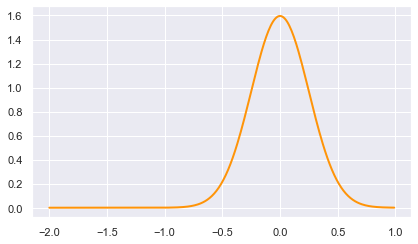

In [3]:
k_trap = 16
init_var = 1 / k_trap
fpe.initializeProbability(0, init_var)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, fpe.prob, linewidth=2.0, color=sns.xkcd_rgb["tangerine"])
plt.tight_layout()
plt.show()


In [4]:
fpe.check_CFL(([k_trap, 0]), ff.harmonicForce)

		CFL criterion satisfied, CFL --> 0.8




True

In [5]:
# Now we can initialize the probability to the right of the trap minimum, and
# observe the relaxatiojn of probability towards the equilibrtium state
fpe.initializeProbability(-1, init_var)

t_tot = 0.25
curr_time = 0
counter = 0
prob_tracker = []

while curr_time < t_tot:
    if counter % 10 == 0:
        prob_tracker.append(fpe.prob.copy())
    fpe.integrate_step(([k_trap, 0]), ff.harmonicForce)
    counter += 1
    curr_time += fpe.dt

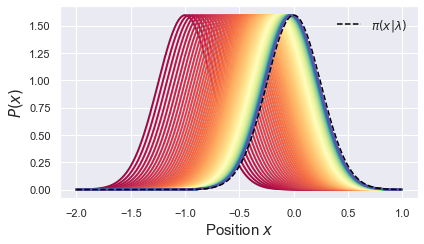

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("Spectral", len(prob_tracker))
for i, prob in enumerate(prob_tracker):
    ax.plot(fpe.xArray, prob, color=Pal[i], linewidth=2.0)

eq_dist = np.exp(-ff.harmonicEnergy(fpe.xArray, (k_trap, 0)))
eq_dist = eq_dist / (np.sum(eq_dist) * fpe.dx)
ax.plot(fpe.xArray, eq_dist, 'k--', label="$\pi(x|\lambda)$")

ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x)$", fontsize=15)
ax.legend(fontsize=12, frameon=False)
plt.tight_layout()

In [7]:
# Now, we can also track the mean and variance of a distribution during
# relaxation to see if the expected relationships are obeyed

def calc_mean(prob: np.ndarray, x_vals: np.ndarray):
    dX = x_vals[1] - x_vals[0]
    return np.sum(x_vals * prob * dX)

def calc_variance(prob: np.ndarray, x_vals:np.ndarray):
    dX = x_vals[1] - x_vals[0]
    mean = calc_mean(prob, x_vals)
    return np.sum((x_vals - mean)**2 * prob * dX)


fpe.initializeProbability(-1, 2 * init_var)

t_tot = 0.30
curr_time = 0
counter = 0

prob_tracker = []
mean_tracker = []
var_tracker = []
time_tracker = []

while curr_time < t_tot:
    if counter % 10 == 0:
        prob_tracker.append(fpe.prob.copy())
        mean_tracker.append(calc_mean(fpe.prob.copy(), fpe.xArray))
        var_tracker.append(calc_variance(fpe.prob.copy(), fpe.xArray))
        time_tracker.append(curr_time)

    fpe.integrate_step(([k_trap, 0]), ff.harmonicForce)
    counter += 1
    curr_time += fpe.dt


Text(0.5, 0, 'Time $t$')

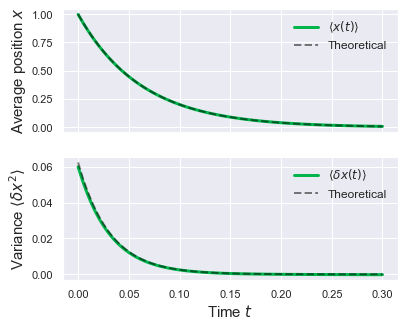

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax[0].plot(time_tracker, np.abs(mean_tracker), linewidth=3.0, label=r"$\langle x(t)\rangle$", color=sns.xkcd_rgb["shamrock"])
ax[1].plot(time_tracker, np.array(var_tracker) - init_var, linewidth=3.0, label=r"$\langle\delta x(t)\rangle$", color=sns.xkcd_rgb["shamrock"])

ax[0].plot(time_tracker, np.exp(-np.array(time_tracker) * k_trap), 'k--', linewidth=2.0, alpha=0.5, label="Theoretical")
ax[1].plot(time_tracker, init_var * np.exp(-np.array(time_tracker) * k_trap * 2), 'k--', linewidth=2.0, alpha=0.5, label="Theoretical")

ax[0].legend(fontsize=12, frameon=False)
ax[1].legend(fontsize=12, frameon=False)

ax[0].set_ylabel(r"Average position $x$", fontsize=15)
ax[1].set_ylabel(r"Variance $\langle\delta x^2\rangle$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)


In [9]:
# So, from this we can see that the theoretical behavivour is paralleled by the cauclations
# to be sure we can run a set of these simulations for different values of 'D' to be sure
# that the dynamics are accurately reproduced

class SimulationResult:
    def __init__(
        self, prob_tracker: Iterable, mean_tracker: Iterable,
        variance_tracker: Iterable, time_tracker: Iterable, x_array: np.ndarray
    ):
        self.result = {
            "prob": prob_tracker,
            "mean": mean_tracker,
            "variance": variance_tracker,
            "time": time_tracker,
            "x_array": x_array
        }


def run_simulation(
    diff: float, dx: Optional[float] = 0.01, dt: Optional[float] = 0.00025
) -> SimulationResult:
    x_array = np.arange(-2, 1, dx)
    init_var = 1/16

    prob_tracker = []
    mean_tracker = []
    var_tracker = []
    time_tracker = []

    fpe = FPE_Integrator_1D(
        diff, dt, dx, x_array, boundaryCond="hard-wall", output=False
    )
    fpe.initializeProbability(-1, 2 * init_var)

    curr_time = 0
    counter = 0
    t_tot = 0.35

    while curr_time < t_tot:
        if counter % 10 == 0:
            prob_tracker.append(fpe.prob.copy())
            mean_tracker.append(calc_mean(fpe.prob.copy(), fpe.xArray))
            var_tracker.append(calc_variance(fpe.prob.copy(), fpe.xArray))
            time_tracker.append(curr_time)

        fpe.integrate_step(([k_trap, 0]), ff.harmonicForce)
        counter += 1
        curr_time += dt

    return SimulationResult(
        prob_tracker, mean_tracker, var_tracker, time_tracker, x_array
    )

res_025 = run_simulation(0.25)
res_05 = run_simulation(0.5)
res_1 = run_simulation(1)
res_2 = run_simulation(2)


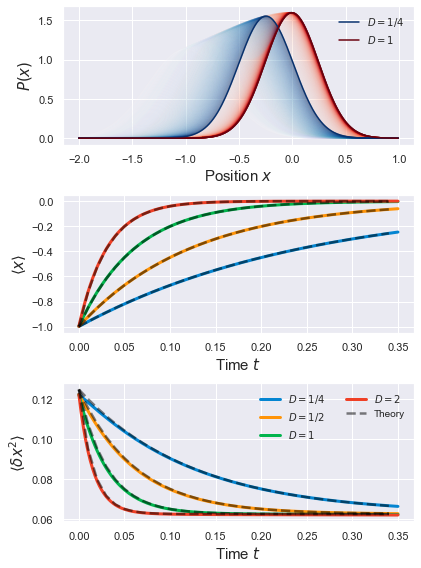

In [10]:
# Now lets plot them...
fig, ax = plt.subplots(3, 1, figsize=(6, 8))

Pal_1 = sns.color_palette("Blues", len(res_025.result["prob"]))
Pal_2 = sns.color_palette("Reds", len(res_1.result["prob"]))

for i, (p1, p2) in enumerate(zip(res_025.result["prob"], res_1.result["prob"])):
    ax[0].plot(res_025.result["x_array"], p1, color=Pal_1[i], alpha=0.1)
    ax[0].plot(res_1.result["x_array"], p2, color=Pal_2[i], alpha=0.1)

ax[0].plot(res_025.result["x_array"], res_025.result["prob"][-1], color=Pal_1[-1], alpha=1, label=r"$D=1/4$")
ax[0].plot(res_1.result["x_array"], res_1.result["prob"][-1], color=Pal_2[-1], alpha=1, label=r"$D=1$")

ax[1].plot(res_025.result["time"], res_025.result["mean"], linewidth=3.0, color=sns.xkcd_rgb["cerulean"], label=r"$D=1/4$")
ax[1].plot(res_05.result["time"], res_05.result["mean"], linewidth=3.0, color=sns.xkcd_rgb["tangerine"], label=r"$D=1/2$")
ax[1].plot(res_1.result["time"], res_1.result["mean"], linewidth=3.0, color=sns.xkcd_rgb["shamrock"], label=r"$D=1$")
ax[1].plot(res_2.result["time"], res_2.result["mean"], linewidth=3.0, color=sns.xkcd_rgb["tomato"], label=r"$D=2$")

ax[2].plot(res_025.result["time"], res_025.result["variance"], linewidth=3.0, color=sns.xkcd_rgb["cerulean"], label=r"$D=1/4$")
ax[2].plot(res_05.result["time"], res_05.result["variance"], linewidth=3.0, color=sns.xkcd_rgb["tangerine"], label=r"$D=1/2$")
ax[2].plot(res_1.result["time"], res_1.result["variance"], linewidth=3.0, color=sns.xkcd_rgb["shamrock"], label=r"$D=1$")
ax[2].plot(res_2.result["time"], res_2.result["variance"], linewidth=3.0, color=sns.xkcd_rgb["tomato"], label=r"$D=2$")

time_theory = np.arange(0, 0.35, 0.01)
ax[1].plot(time_theory, -np.exp(-np.array(time_theory) * k_trap * 0.25), 'k--', linewidth=2.5, alpha=0.5)
ax[1].plot(time_theory, -np.exp(-np.array(time_theory) * k_trap * 0.5), 'k--', linewidth=2.5, alpha=0.5)
ax[1].plot(time_theory, -np.exp(-np.array(time_theory) * k_trap * 1), 'k--', linewidth=2.5, alpha=0.5)
ax[1].plot(time_theory, -np.exp(-np.array(time_theory) * k_trap * 2), 'k--', linewidth=2.5, alpha=0.5)

ax[2].plot(time_theory, init_var + init_var * np.exp(-np.array(time_theory) * k_trap * 2 * 0.25), 'k--', linewidth=2.5, alpha=0.5)
ax[2].plot(time_theory, init_var + init_var * np.exp(-np.array(time_theory) * k_trap * 2 * 0.5), 'k--', linewidth=2.5, alpha=0.5)
ax[2].plot(time_theory, init_var + init_var * np.exp(-np.array(time_theory) * k_trap * 2 * 1), 'k--', linewidth=2.5, alpha=0.5)
ax[2].plot(time_theory, init_var + init_var * np.exp(-np.array(time_theory) * k_trap * 2 * 2), 'k--', linewidth=2.5, alpha=0.5, label="Theory")

ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_ylabel(r"$\langle x\rangle$", fontsize=15)
ax[2].set_ylabel(r"$\langle\delta x^2\rangle$", fontsize=15)

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_xlabel(r"Time $t$", fontsize=15)

ax[0].legend(fontsize=10, frameon=False)
ax[2].legend(fontsize=10, frameon=False, ncol=2)

plt.tight_layout()


From the figure above, we can tell that the simulating dynamics, for a variety of diffusion coefficients, are emulating the correct theoretical expressions. Ultimately, this indicates that the combination of both the advection and diffusion integrators (separately implemented using a Strang splitting method) are accuately portraying the desired physics.

To further test this, we look at the theoretical values for work and power done by a controller pushing a harmonic trap at a constant velocity $\dot{\lambda}$. Specifically, we consider a system which is initially at equilibirum, and then the trap minmum begins to move at a constant velocity. In this scenario, the total work done on the diffusing particle was shown analytically in Ref.[1] to be

$$ \langle W\rangle = \frac{\dot{\lambda}^2}{\beta D} \left[ \tau - \frac{1 - e^{-\beta D k \tau}}{\beta D k} \right] $$

analagously, the power (or rate of work done) is given by 

$$ \langle P \rangle = \frac{\dot{\lambda}^2}{\beta D}\left( 1 - e^{-k D k\tau} \right) $$

For these calcultions it is much more convenient to transform the FPE into a reference frame which is moving with theharmonic potential. Specifically, we chagne the position $x$ to be $z = \lambda - x$--the difference between the trap minimum and the particle.  Transforming the equation in this way gives rise to a new FPE of the same form, but now with a force of the form

$$ F_{\rm moving}(z) = -kz - \frac{\dot{\lambda}}{\beta D}$$

which effectively imposes an additional linear drag force on the system.


In [45]:
# Now move on to work measurements and power calculations

# Procedure to calculate:
# - Initialize system in equilibrium distribution
# - Start moving trap
# - Dynamics will be under 'modified' Smoluchowski equation, with force term present
# - Calculate work based on change in energy of current probability through time
# - Compare with theoretical result
import copy

fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='hard-wall', output=False)
fpe.initializeProbability(0, init_var)

fpe_025 = copy.deepcopy(fpe)
fpe_05 = copy.deepcopy(fpe)
fpe_1 = copy.deepcopy(fpe)
fpe_2 = copy.deepcopy(fpe)

lambda_vel = [0.25, 0.5, 0.75, 1.0]
curr_time = 0
counter = 0
tot_time = 0.15
params = [[k_trap, vel, D, 1, 0] for vel in lambda_vel]
params_new = [[k_trap, vel, D, 1, vel * dt] for vel in lambda_vel]

prob_tracker = []
time_tracker = []
time_tracker_prob = []

while curr_time < tot_time:
    if counter % 10 == 0:
        prob_tracker.append(fpe_1.prob.copy())
        time_tracker_prob.append(curr_time)

    fpe_025.work_step(params[0], params_new[0], ff.harmonicForce_constVel, ff.harmonicEnergy_constVel)
    fpe_05.work_step(params[1], params_new[1], ff.harmonicForce_constVel, ff.harmonicEnergy_constVel)
    fpe_1.work_step(params[2], params_new[2], ff.harmonicForce_constVel, ff.harmonicEnergy_constVel)
    fpe_2.work_step(params[3], params_new[3], ff.harmonicForce_constVel, ff.harmonicEnergy_constVel)

    time_tracker.append(curr_time)
    curr_time += dt
    counter += 1




$$ \langle W\rangle = \frac{\dot{\lambda}^2}{\beta D} \left[ \tau - \frac{1 - e^{-\beta D k \tau}}{\beta D k} \right] $$

analagously, the power (or rate of work done) is given by 

$$ \langle P \rangle = \frac{\dot{\lambda}^2}{\beta D}\left( 1 - e^{-k D k\tau} \right) $$

In [46]:
# Theoretical values (Mazonka and Jarzynski)
def get_harmonic_work(time: np.ndarray, lambda_vel: float, k_trap: float) -> np.ndarray:
    return lambda_vel**2 * (time - (1 - np.exp(-k_trap * time))/k_trap)

def get_harmonic_power(time: np.ndarray, lambda_vel: float, k_trap: float) -> np.ndarray:
    return lambda_vel**2 * (1 - np.exp(-k_trap * time))



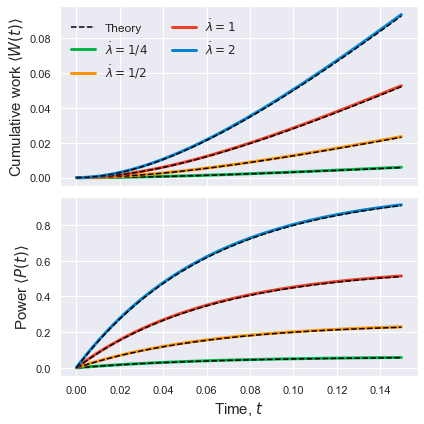

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# vel = 1/4
ax[0].plot(time_tracker, get_harmonic_work(np.array(time_tracker), lambda_vel[0], k_trap), 'k--', label=r"Theory")
ax[0].plot(time_tracker, fpe_025.workTracker, color=sns.xkcd_rgb["shamrock"], linewidth=3.0, label=r"$\dot{\lambda} = 1/4$")
ax[1].plot(time_tracker, fpe_025.powerTracker, color=sns.xkcd_rgb["shamrock"], linewidth=3.0, label=r"$\dot{\lambda} = 1/4$")
ax[0].plot(time_tracker, get_harmonic_work(np.array(time_tracker), lambda_vel[0], k_trap), 'k--')
ax[1].plot(time_tracker, get_harmonic_power(np.array(time_tracker), lambda_vel[0], k_trap), 'k--')

# vel = 1/2
ax[0].plot(time_tracker, fpe_05.workTracker, color=sns.xkcd_rgb["tangerine"], linewidth=3.0, label=r"$\dot{\lambda} = 1/2$")
ax[1].plot(time_tracker, fpe_05.powerTracker, color=sns.xkcd_rgb["tangerine"], linewidth=3.0, label=r"$\dot{\lambda} = 1/2$")
ax[0].plot(time_tracker, get_harmonic_work(np.array(time_tracker), lambda_vel[1], k_trap), 'k--')
ax[1].plot(time_tracker, get_harmonic_power(np.array(time_tracker), lambda_vel[1], k_trap), 'k--')

# vel = 1
ax[0].plot(time_tracker, fpe_1.workTracker, color=sns.xkcd_rgb["tomato"], linewidth=3.0, label=r"$\dot{\lambda} = 1$")
ax[1].plot(time_tracker, fpe_1.powerTracker, color=sns.xkcd_rgb["tomato"], linewidth=3.0, label=r"$\dot{\lambda} = 1$")
ax[0].plot(time_tracker, get_harmonic_work(np.array(time_tracker), lambda_vel[2], k_trap), 'k--')
ax[1].plot(time_tracker, get_harmonic_power(np.array(time_tracker), lambda_vel[2], k_trap), 'k--')

# vel = 2
ax[0].plot(time_tracker, fpe_2.workTracker, color=sns.xkcd_rgb["cerulean"], linewidth=3.0, label=r"$\dot{\lambda} = 2$")
ax[1].plot(time_tracker, fpe_2.powerTracker, color=sns.xkcd_rgb["cerulean"], linewidth=3.0, label=r"$\dot{\lambda} = 2$")
ax[0].plot(time_tracker, get_harmonic_work(np.array(time_tracker), lambda_vel[3], k_trap), 'k--')
ax[1].plot(time_tracker, get_harmonic_power(np.array(time_tracker), lambda_vel[3], k_trap), 'k--')

ax[0].legend(fontsize=12, frameon=False, ncol=2)
ax[1].set_xlabel(r"Time, $t$", fontsize=15)
ax[0].set_ylabel(r"Cumulative work $\langle W(t)\rangle$", fontsize=15)
ax[1].set_ylabel(r"Power $\langle P(t)\rangle$", fontsize=15)

plt.tight_layout()

So, from these results, we can see that the work and power calculations from the integrator reproduce the theoretical predictions for several different control parameter velocities $\dot{\lambda}$